# Pre-processing NMR
The pre-processing of the NMR consists of removing the head and tail of the data, after which the dataset is merged with the original patient IDs.

In [1]:
import pandas as pd
import os
import sys
sys.path.append("../../src")

DATA_FOLDER = "../../datasets.nosync/"

def pre_process_nmr(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pre-process the NMR data by removing the head and tail of the spectrum.

    :param df: df containing the NMR data.
    :return: pre-processed df.
    """
    df.loc[(df["Chemical Shifts"] > 9.0) & (df["PPM"] != 0), ["PPM"]] = 0
    df.loc[(df["Chemical Shifts"] < -0.5) & (df["PPM"] != 0), ["PPM"]] = 0
    df = df[df["Chemical Shifts"] < 9.0]
    df = df[df["Chemical Shifts"] > -0.5]
    return df

In [2]:
nmr_df = pd.read_feather(os.path.join(DATA_FOLDER, "0_nmr.feather"))
labcorp_df = pd.read_csv(os.path.join(DATA_FOLDER, "0_labcorp.csv"))

/Users/otoz/miniconda3/envs/thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


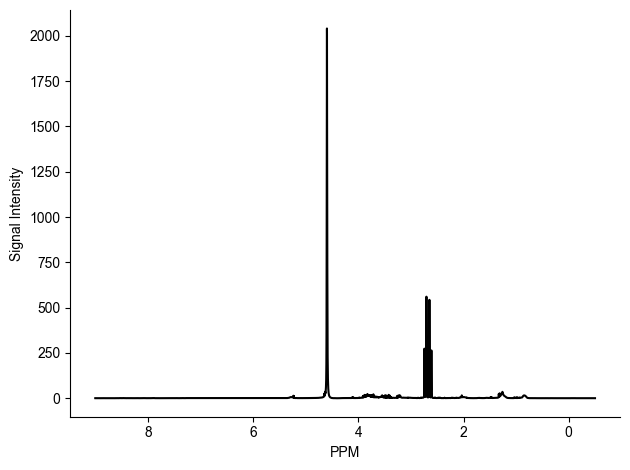

In [3]:
from visualization import plot_one_spectrum

nmr_df = pre_process_nmr(nmr_df)
plot_one_spectrum(nmr_df)
nmr_df = nmr_df.pivot(index="ID", columns="Chemical Shifts", values="PPM")
nmr_df.to_csv(os.path.join(DATA_FOLDER, "nmr_preprocessed.csv"), index=True)
nmr_df = pd.read_csv(os.path.join(DATA_FOLDER, "nmr_preprocessed.csv"))

In [4]:
# match the ids
labcorp_df = labcorp_df.rename(columns={"SampleID": "ID"})
nmr_df = nmr_df[nmr_df["ID"].isin(labcorp_df["ID"])]

# add PK column to corresponding id
nmr_df = nmr_df.merge(labcorp_df[["ID", "PK"]], on="ID", how="inner")
nmr_df.drop(columns=["ID"], inplace=True)
nmr_columns = [c for c in nmr_df.columns if c not in ["PK"]]

# Pre-processing Clinical data
The pre-processing of the clinical dataset will perform the following steps:
- Remove all NA-values for survival and glucose.
- Remove patients with diabetes at baseline.
- Use the pre-selection of features to filter the features to use.
- Turn categorical features into numerical instead.

In [5]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd

prevend_df = pd.read_spss(os.path.join(DATA_FOLDER, "0_PREVEND.sav"))

prevend_df = prevend_df.replace(["Yes", "yes", "ja", "Ja", " Yes"], True)
prevend_df = prevend_df.replace(["No", "no", " No", "nee"], False)
prevend_df = prevend_df.replace([-99.0], pd.NA)
prevend_df["diabeet_nc1"] = prevend_df["diabeet_nc1"].astype(bool)
prevend_df["diabeet_nc2"] = prevend_df["diabeet_nc2"].astype(bool)
prevend_df["Diabeet_nc3"] = prevend_df["Diabeet_nc3"].astype(bool)
prevend_df["Diabeet_NC4"] = prevend_df["Diabeet_NC4"].astype(bool)
prevend_df["Diabeet_NC5"] = prevend_df["Diabeet_NC5"].astype(bool)

# Remove NaN values for GLUC_2 and SURVIVAL
prevend_df = prevend_df.dropna(subset=["GLUC_2"], inplace=False, axis=0).dropna(subset=["SURVIVAL"], inplace=False, axis=0)

# Keep everyone without diabetes and with a glucose level below 7.0
prevend_df = prevend_df[
    (prevend_df["GLUC_2"] < 7.0)
    & (prevend_df["diabeet_nc1"] != True)
    & (prevend_df["diabeet_nc2"] != True)
]

# Keep everyone that is either False in nc2 or unknown in nc2 but false in nc3, nc4, or nc5
prevend_df = prevend_df[
    (prevend_df["diabeet_nc2"] == False)
    & (prevend_df["diabeet_nc2"].isna() & prevend_df["Diabeet_nc3"] == False)
    & (prevend_df["diabeet_nc2"].isna() & prevend_df["Diabeet_NC4"] == False)
    & (prevend_df["diabeet_nc2"].isna() & prevend_df["Diabeet_NC5"] == False)
]
diabetes_event = prevend_df.drop(["diabeet_nc1", "diabeet_nc2"], axis=1, inplace=False)

diabetes_event = diabetes_event[
    [
        col
        for col in prevend_df.columns
        if col
        in [
            "Diabeet_CASE_1",
            "SURVIVAL",
            "PK",
            "GLUC_2"
        ]
    ]
]

diabetes_event["CENSORED"] = (
    diabetes_event["Diabeet_CASE_1"] == False
).astype(int)
diabetes_event = diabetes_event[["SURVIVAL", "CENSORED", "PK", "GLUC_2"]]

diabetes_censored = diabetes_event["CENSORED"].value_counts()
print(
    f"Diabetes events: {diabetes_censored[0]} / {diabetes_censored[1]} = {diabetes_censored[0] / diabetes_censored[1] * 100}%"
)

Diabetes events: 294 / 4968 = 5.917874396135265%


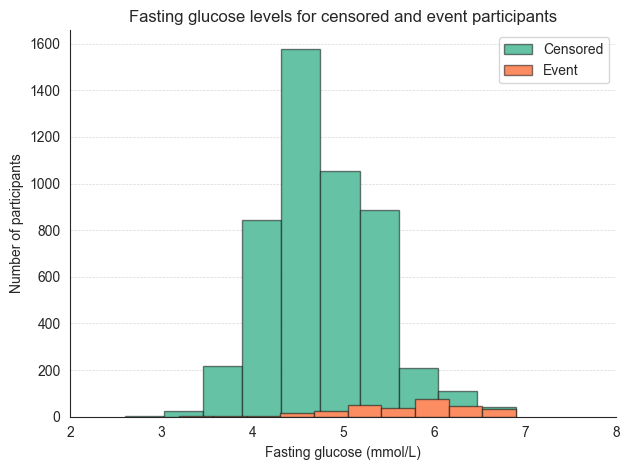

In [6]:
from visualization import plot_glucose_levels

plot_glucose_levels(diabetes_event)

In [7]:
with open("prevend_columns.txt", "r") as f:
    keep_columns = [c.strip("\n").strip() for c in f.readlines()]
filtered_df = prevend_df[keep_columns]

# Keep everyone who has drank or eaten less than 1 cup or 1 cracker
filtered_df = filtered_df[
    (filtered_df["EAT_2B"] != ">1 cracker")
    & (filtered_df["DRINK_2B"] != "> 1 cup of tea")
]

filtered_df = filtered_df.drop(["EAT_2B", "DRINK_2B"], axis=1, inplace=False)
# take the mean of variables with two measurements
two_measurements = [
    "UAC",
    "UK",
    "UNA",
    "UUR",
    "UUZ",
    "UCREA",
]

for m in two_measurements:
    filtered_df[m] = filtered_df[[f"{m}1_2B", f"{m}2_2B"]].mean(axis=1)
    filtered_df = filtered_df.drop([f"{m}1_2B", f"{m}2_2B"], axis=1)

# HYP if either HYP1 or HYP2 is True
filtered_df["HYP"] = filtered_df["HYP_1"].astype(bool) | filtered_df["HYP_2"].astype(
    bool
).astype(bool)
filtered_df = filtered_df.drop(["HYP_1", "HYP_2"], axis=1)
filtered_df = filtered_df.drop(["GLUC_2"], axis=1)

In [8]:
import numpy as np

mapping_dict = {}
for c in filtered_df.columns:
    if c in ["SURVIVAL", "CENSORED", "PK"]:
        continue
    if filtered_df[c].dtype not in ["float64", "bool"]:
        unique_values = list(filtered_df[c].values.categories)
        mapping_dict[c] = {v: i for i, v in enumerate(unique_values)}
    elif filtered_df[c].dtype == "bool":
        mapping_dict[c] = {True: 1, False: 0}
    if c in mapping_dict:
        filtered_df.loc[:, c] = filtered_df[c].map(mapping_dict[c])
prevend_columns = [c for c in filtered_df.columns if c not in ["SURVIVAL", "CENSORED", "PK"]] + ["GLUC_2"]

# Split & save

In [9]:
from sklearn.model_selection import train_test_split

full_features = nmr_df.merge(filtered_df, on="PK", how="inner")
full_df = full_features.merge(diabetes_event, on="PK", how="inner")
full_df = full_df.drop(columns=["PK"])

# create label columns
full_df["lower_bound"] = full_df["SURVIVAL"]

# upper boundary is survival if censored, +inf otherwise
full_df["upper_bound"] = full_df["SURVIVAL"]
full_df.loc[full_df["CENSORED"] == 1, "upper_bound"] = np.inf
full_df = full_df.drop(columns=["SURVIVAL"])

train, test = train_test_split(
    full_df, test_size=0.2, stratify=full_df["CENSORED"], random_state=42
)
print(full_df["CENSORED"].value_counts())
print(train["CENSORED"].value_counts())
print(test["CENSORED"].value_counts())

CENSORED
1    4083
0     225
Name: count, dtype: int64
CENSORED
1    3266
0     180
Name: count, dtype: int64
CENSORED
1    817
0     45
Name: count, dtype: int64


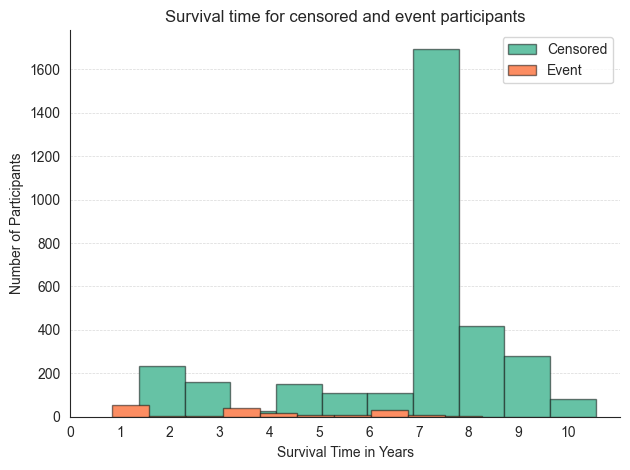

In [10]:
from visualization import plot_survival

plot_survival(train)

In [11]:
train[prevend_columns + ["CENSORED", "lower_bound", "upper_bound"]].to_csv(
    "../../datasets.nosync/clinical_train.csv", index=False
)
train[nmr_columns + ["CENSORED", "lower_bound", "upper_bound"]].to_csv(
    "../../datasets.nosync/nmr_train.csv", index=False
)
train.to_csv("../../datasets.nosync/full_train.csv", index=False)

test[prevend_columns + ["CENSORED", "lower_bound", "upper_bound"]].to_csv(
    "../../datasets.nosync/clinical_test.csv", index=False
)
test[nmr_columns + ["CENSORED", "lower_bound", "upper_bound"]].to_csv(
    "../../datasets.nosync/nmr_test.csv", index=False
)
test.to_csv("../../datasets.nosync/full_test.csv", index=False)